In [26]:
"""
Author: Alan, Chen
Email: alanchen0922@gmail.com

paper:
"""

'\nAuthor: Alan, Chen\nEmail: alanchen0922@gmail.com\n\npaper:\n'

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import Function
from torch.nn.modules.module import Module
import numpy as np

from torchsummary import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [28]:
def read_bci_data():
    S4b_train = np.load('S4b_train.npz')
    X11b_train = np.load('X11b_train.npz')
    S4b_test = np.load('S4b_test.npz')
    X11b_test = np.load('X11b_test.npz')

    train_data = np.concatenate((S4b_train['signal'], X11b_train['signal']), axis=0)
    train_label = np.concatenate((S4b_train['label'], X11b_train['label']), axis=0)
    test_data = np.concatenate((S4b_test['signal'], X11b_test['signal']), axis=0)
    test_label = np.concatenate((S4b_test['label'], X11b_test['label']), axis=0)

    train_label = train_label - 1
    test_label = test_label -1
    train_data = np.transpose(np.expand_dims(train_data, axis=1), (0, 1, 3, 2))
    test_data = np.transpose(np.expand_dims(test_data, axis=1), (0, 1, 3, 2))

    mask = np.where(np.isnan(train_data))
    train_data[mask] = np.nanmean(train_data)

    mask = np.where(np.isnan(test_data))
    test_data[mask] = np.nanmean(test_data)

    print(train_data.shape, train_label.shape, test_data.shape, test_label.shape)

    return train_data, train_label, test_data, test_label

In [97]:
class DeepConvNet(nn.Module):
    def __init__(self):
        super(DeepConvNet, self).__init__()
        self.T = 750
        self.C = 2
        self.classes = 2
        self.dropout_rate = 0.5
        
        self.conv1 = nn.Conv2d(1, 25, kernel_size=(1, 5))
        
        self.conv2 = nn.Conv2d(25, 25, kernel_size=(self.C, 1))
        self.batchnorm1 = nn.BatchNorm2d(25)
#         self.relu1 = nn.ReLU()
#         self.leakyrelu1 = nn.LeakyReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=(1, 2))
        self.dropout1 = nn.Dropout(self.dropout_rate)
        
        self.conv3 = nn.Conv2d(25, 50, kernel_size=(1, 5))
        self.batchnorm2 = nn.BatchNorm2d(50)
#         self.relu2 = nn.ReLU()
#         self.leakyrelu2 = nn.LeakyReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=(1, 2))
        self.dropout2 = nn.Dropout(self.dropout_rate)
        
        self.conv4 = nn.Conv2d(50, 100, kernel_size=(1, 5))
        self.batchnorm3 = nn.BatchNorm2d(100)
#         self.relu3 = nn.ReLU()
#         self.leakyrelu3 = nn.LeakyReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=(1, 2))
        self.dropout3 = nn.Dropout(self.dropout_rate)
        
        self.conv5 = nn.Conv2d(100, 200, kernel_size=(1, 5))
        self.batchnorm4 = nn.BatchNorm2d(200)
#         self.relu4 = nn.ReLU()
#         self.leakyrelu4 = nn.LeakyReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=(1, 2))
        self.dropout4 = nn.Dropout(self.dropout_rate)
        
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(8600, self.classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.batchnorm1(x)
        x = F.elu(x)
#         x = self.relu1(x)
#         x = self.leakyrelu1(x)
        x = self.maxpool1(x)
        x = self.dropout1(x)
        
        x = self.conv3(x)
        x = self.batchnorm2(x)
        x = F.elu(x)
#         x - self.relu2(x)
#         x = self.leakyrelu2(x)
        x = self.maxpool2(x)
        x = self.dropout2(x)
        
        x = self.conv4(x)
        x = self.batchnorm3(x)
        x = F.elu(x)
#         x = self.relu3(x)
#         x = self.leakyrelu3(x)
        x = self.maxpool3(x)
        x = self.dropout3(x)
        
        x = self.conv5(x)
        x = self.batchnorm4(x)
        x = F.elu(x)
#         x = self.relu4(x)
#         x = self.leakyrelu4(x)
        x = self.maxpool4(x)
        x = self.dropout4(x)
        
        x = self.flatten(x)
        x = self.dense(x)
        
        return x
    
model = DeepConvNet().to(device)
# print(model)
summary(model, (1, 2, 750))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 25, 2, 746]             150
            Conv2d-2           [-1, 25, 1, 746]           1,275
       BatchNorm2d-3           [-1, 25, 1, 746]              50
         MaxPool2d-4           [-1, 25, 1, 373]               0
           Dropout-5           [-1, 25, 1, 373]               0
            Conv2d-6           [-1, 50, 1, 369]           6,300
       BatchNorm2d-7           [-1, 50, 1, 369]             100
         MaxPool2d-8           [-1, 50, 1, 184]               0
           Dropout-9           [-1, 50, 1, 184]               0
           Conv2d-10          [-1, 100, 1, 180]          25,100
      BatchNorm2d-11          [-1, 100, 1, 180]             200
        MaxPool2d-12           [-1, 100, 1, 90]               0
          Dropout-13           [-1, 100, 1, 90]               0
           Conv2d-14           [-1, 200

In [98]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    avg_loss, avg_acc = 0, 0
    for batch, (x, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        avg_loss += loss.item()
        avg_acc += (pred.argmax(1) == y).type(torch.float).sum().item()
        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(x)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        
    avg_loss /= len(dataloader)
    avg_acc /= len(dataloader.dataset)
    return 100*avg_acc, avg_loss


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return 100*correct, test_loss

In [99]:
from sklearn import preprocessing

x_train, y_train, x_test, y_test = read_bci_data()

x_train = torch.from_numpy(x_train).float().to(device)
y_train = torch.from_numpy(y_train).type(torch.LongTensor).to(device)

x_test = torch.from_numpy(x_test).float().to(device)
y_test = torch.from_numpy(y_test).type(torch.LongTensor).to(device) # data type is long

train = torch.utils.data.TensorDataset(x_train,y_train)
test = torch.utils.data.TensorDataset(x_test,y_test)

batch_size = 128
train_loader = DataLoader(
    dataset=train,
    batch_size=batch_size,
#     shuffle=True,
)

test_loader = DataLoader(
    dataset=test,
    batch_size=batch_size,
#     shuffle=True,
)

(1080, 1, 2, 750) (1080,) (1080, 1, 2, 750) (1080,)


In [100]:
epochs = 2000
learning_rate = 1e-3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.02)

train_acc = []
train_loss = []
test_acc = []
test_loss = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    tr_acc, tr_loss = train_loop(train_loader, model, loss_fn, optimizer)
    te_acc, te_loss = test_loop(test_loader, model, loss_fn)
    train_acc.append(tr_acc)
    train_loss.append(tr_loss)
    test_acc.append(te_acc)
    test_loss.append(te_loss)
    
    if te_acc > 88. and t > 300:
        break
print("Done!")

print("Saving model weight...")
torch.save(model, "./DeepConvNet_model.pt")
print("Save Done!")

Epoch 1
-------------------------------
loss: 0.797364  [    0/ 1080]
Test Error: 
 Accuracy: 51.1%, Avg loss: 1.651126 

Epoch 2
-------------------------------
loss: 1.567567  [    0/ 1080]
Test Error: 
 Accuracy: 61.3%, Avg loss: 0.938573 

Epoch 3
-------------------------------
loss: 1.143735  [    0/ 1080]
Test Error: 
 Accuracy: 66.2%, Avg loss: 0.732005 

Epoch 4
-------------------------------
loss: 1.090001  [    0/ 1080]
Test Error: 
 Accuracy: 62.9%, Avg loss: 0.931657 

Epoch 5
-------------------------------
loss: 1.348995  [    0/ 1080]
Test Error: 
 Accuracy: 62.9%, Avg loss: 1.037769 

Epoch 6
-------------------------------
loss: 1.481938  [    0/ 1080]
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.719487 

Epoch 7
-------------------------------
loss: 0.944892  [    0/ 1080]
Test Error: 
 Accuracy: 60.6%, Avg loss: 1.084114 

Epoch 8
-------------------------------
loss: 1.680797  [    0/ 1080]
Test Error: 
 Accuracy: 66.0%, Avg loss: 1.086195 

Epoch 9
----------------

Test Error: 
 Accuracy: 76.9%, Avg loss: 0.552910 

Epoch 69
-------------------------------
loss: 0.505048  [    0/ 1080]
Test Error: 
 Accuracy: 78.1%, Avg loss: 0.533228 

Epoch 70
-------------------------------
loss: 0.533199  [    0/ 1080]
Test Error: 
 Accuracy: 77.0%, Avg loss: 0.567314 

Epoch 71
-------------------------------
loss: 0.591058  [    0/ 1080]
Test Error: 
 Accuracy: 77.5%, Avg loss: 0.535312 

Epoch 72
-------------------------------
loss: 0.507044  [    0/ 1080]
Test Error: 
 Accuracy: 77.1%, Avg loss: 0.544513 

Epoch 73
-------------------------------
loss: 0.488400  [    0/ 1080]
Test Error: 
 Accuracy: 76.9%, Avg loss: 0.548410 

Epoch 74
-------------------------------
loss: 0.502285  [    0/ 1080]
Test Error: 
 Accuracy: 76.5%, Avg loss: 0.580468 

Epoch 75
-------------------------------
loss: 0.374406  [    0/ 1080]
Test Error: 
 Accuracy: 74.9%, Avg loss: 0.659068 

Epoch 76
-------------------------------
loss: 0.633896  [    0/ 1080]
Test Error: 
 Ac

Test Error: 
 Accuracy: 78.8%, Avg loss: 0.518844 

Epoch 136
-------------------------------
loss: 0.239265  [    0/ 1080]
Test Error: 
 Accuracy: 76.0%, Avg loss: 0.539023 

Epoch 137
-------------------------------
loss: 0.306646  [    0/ 1080]
Test Error: 
 Accuracy: 79.5%, Avg loss: 0.506736 

Epoch 138
-------------------------------
loss: 0.320679  [    0/ 1080]
Test Error: 
 Accuracy: 79.4%, Avg loss: 0.476311 

Epoch 139
-------------------------------
loss: 0.265455  [    0/ 1080]
Test Error: 
 Accuracy: 78.4%, Avg loss: 0.484047 

Epoch 140
-------------------------------
loss: 0.292115  [    0/ 1080]
Test Error: 
 Accuracy: 78.7%, Avg loss: 0.485074 

Epoch 141
-------------------------------
loss: 0.262889  [    0/ 1080]
Test Error: 
 Accuracy: 80.9%, Avg loss: 0.451758 

Epoch 142
-------------------------------
loss: 0.296814  [    0/ 1080]
Test Error: 
 Accuracy: 79.4%, Avg loss: 0.489912 

Epoch 143
-------------------------------
loss: 0.296019  [    0/ 1080]
Test Err

Test Error: 
 Accuracy: 80.0%, Avg loss: 0.475867 

Epoch 203
-------------------------------
loss: 0.339596  [    0/ 1080]
Test Error: 
 Accuracy: 79.8%, Avg loss: 0.479288 

Epoch 204
-------------------------------
loss: 0.216267  [    0/ 1080]
Test Error: 
 Accuracy: 79.4%, Avg loss: 0.476847 

Epoch 205
-------------------------------
loss: 0.310239  [    0/ 1080]
Test Error: 
 Accuracy: 80.0%, Avg loss: 0.466416 

Epoch 206
-------------------------------
loss: 0.206724  [    0/ 1080]
Test Error: 
 Accuracy: 78.3%, Avg loss: 0.487058 

Epoch 207
-------------------------------
loss: 0.293575  [    0/ 1080]
Test Error: 
 Accuracy: 79.1%, Avg loss: 0.466268 

Epoch 208
-------------------------------
loss: 0.312864  [    0/ 1080]
Test Error: 
 Accuracy: 78.4%, Avg loss: 0.469949 

Epoch 209
-------------------------------
loss: 0.276727  [    0/ 1080]
Test Error: 
 Accuracy: 78.0%, Avg loss: 0.496098 

Epoch 210
-------------------------------
loss: 0.275110  [    0/ 1080]
Test Err

Test Error: 
 Accuracy: 78.6%, Avg loss: 0.483101 

Epoch 270
-------------------------------
loss: 0.227897  [    0/ 1080]
Test Error: 
 Accuracy: 78.9%, Avg loss: 0.536721 

Epoch 271
-------------------------------
loss: 0.277256  [    0/ 1080]
Test Error: 
 Accuracy: 79.4%, Avg loss: 0.476187 

Epoch 272
-------------------------------
loss: 0.235956  [    0/ 1080]
Test Error: 
 Accuracy: 80.6%, Avg loss: 0.478112 

Epoch 273
-------------------------------
loss: 0.224689  [    0/ 1080]
Test Error: 
 Accuracy: 79.5%, Avg loss: 0.481430 

Epoch 274
-------------------------------
loss: 0.252873  [    0/ 1080]
Test Error: 
 Accuracy: 79.0%, Avg loss: 0.490515 

Epoch 275
-------------------------------
loss: 0.277007  [    0/ 1080]
Test Error: 
 Accuracy: 79.2%, Avg loss: 0.512673 

Epoch 276
-------------------------------
loss: 0.243497  [    0/ 1080]
Test Error: 
 Accuracy: 79.9%, Avg loss: 0.485513 

Epoch 277
-------------------------------
loss: 0.265721  [    0/ 1080]
Test Err

Test Error: 
 Accuracy: 78.7%, Avg loss: 0.481827 

Epoch 337
-------------------------------
loss: 0.248455  [    0/ 1080]
Test Error: 
 Accuracy: 78.2%, Avg loss: 0.515008 

Epoch 338
-------------------------------
loss: 0.243858  [    0/ 1080]
Test Error: 
 Accuracy: 78.2%, Avg loss: 0.495540 

Epoch 339
-------------------------------
loss: 0.170903  [    0/ 1080]
Test Error: 
 Accuracy: 79.9%, Avg loss: 0.469251 

Epoch 340
-------------------------------
loss: 0.284113  [    0/ 1080]
Test Error: 
 Accuracy: 78.5%, Avg loss: 0.511413 

Epoch 341
-------------------------------
loss: 0.212718  [    0/ 1080]
Test Error: 
 Accuracy: 79.7%, Avg loss: 0.458630 

Epoch 342
-------------------------------
loss: 0.274409  [    0/ 1080]
Test Error: 
 Accuracy: 77.4%, Avg loss: 0.514358 

Epoch 343
-------------------------------
loss: 0.213839  [    0/ 1080]
Test Error: 
 Accuracy: 80.0%, Avg loss: 0.504097 

Epoch 344
-------------------------------
loss: 0.259051  [    0/ 1080]
Test Err

Test Error: 
 Accuracy: 76.7%, Avg loss: 0.530157 

Epoch 404
-------------------------------
loss: 0.278157  [    0/ 1080]
Test Error: 
 Accuracy: 80.2%, Avg loss: 0.519230 

Epoch 405
-------------------------------
loss: 0.237607  [    0/ 1080]
Test Error: 
 Accuracy: 78.0%, Avg loss: 0.515585 

Epoch 406
-------------------------------
loss: 0.232241  [    0/ 1080]
Test Error: 
 Accuracy: 79.4%, Avg loss: 0.487653 

Epoch 407
-------------------------------
loss: 0.197163  [    0/ 1080]
Test Error: 
 Accuracy: 78.1%, Avg loss: 0.519065 

Epoch 408
-------------------------------
loss: 0.293202  [    0/ 1080]
Test Error: 
 Accuracy: 77.5%, Avg loss: 0.507360 

Epoch 409
-------------------------------
loss: 0.262338  [    0/ 1080]
Test Error: 
 Accuracy: 78.8%, Avg loss: 0.491247 

Epoch 410
-------------------------------
loss: 0.227451  [    0/ 1080]
Test Error: 
 Accuracy: 79.1%, Avg loss: 0.476417 

Epoch 411
-------------------------------
loss: 0.246638  [    0/ 1080]
Test Err

Test Error: 
 Accuracy: 78.4%, Avg loss: 0.521156 

Epoch 471
-------------------------------
loss: 0.237749  [    0/ 1080]
Test Error: 
 Accuracy: 79.5%, Avg loss: 0.501727 

Epoch 472
-------------------------------
loss: 0.275259  [    0/ 1080]
Test Error: 
 Accuracy: 78.7%, Avg loss: 0.504202 

Epoch 473
-------------------------------
loss: 0.189748  [    0/ 1080]
Test Error: 
 Accuracy: 79.9%, Avg loss: 0.493268 

Epoch 474
-------------------------------
loss: 0.331939  [    0/ 1080]
Test Error: 
 Accuracy: 78.7%, Avg loss: 0.506632 

Epoch 475
-------------------------------
loss: 0.198845  [    0/ 1080]
Test Error: 
 Accuracy: 79.4%, Avg loss: 0.485356 

Epoch 476
-------------------------------
loss: 0.256012  [    0/ 1080]
Test Error: 
 Accuracy: 77.8%, Avg loss: 0.510751 

Epoch 477
-------------------------------
loss: 0.242284  [    0/ 1080]
Test Error: 
 Accuracy: 77.6%, Avg loss: 0.524824 

Epoch 478
-------------------------------
loss: 0.209171  [    0/ 1080]
Test Err

Test Error: 
 Accuracy: 79.0%, Avg loss: 0.494249 

Epoch 538
-------------------------------
loss: 0.226575  [    0/ 1080]
Test Error: 
 Accuracy: 79.3%, Avg loss: 0.489646 

Epoch 539
-------------------------------
loss: 0.197880  [    0/ 1080]
Test Error: 
 Accuracy: 78.7%, Avg loss: 0.502354 

Epoch 540
-------------------------------
loss: 0.257913  [    0/ 1080]
Test Error: 
 Accuracy: 76.7%, Avg loss: 0.552361 

Epoch 541
-------------------------------
loss: 0.219333  [    0/ 1080]
Test Error: 
 Accuracy: 76.5%, Avg loss: 0.542608 

Epoch 542
-------------------------------
loss: 0.180580  [    0/ 1080]
Test Error: 
 Accuracy: 79.3%, Avg loss: 0.514021 

Epoch 543
-------------------------------
loss: 0.228208  [    0/ 1080]
Test Error: 
 Accuracy: 80.1%, Avg loss: 0.487820 

Epoch 544
-------------------------------
loss: 0.279970  [    0/ 1080]
Test Error: 
 Accuracy: 79.2%, Avg loss: 0.510158 

Epoch 545
-------------------------------
loss: 0.227622  [    0/ 1080]
Test Err

Test Error: 
 Accuracy: 78.1%, Avg loss: 0.512620 

Epoch 605
-------------------------------
loss: 0.250715  [    0/ 1080]
Test Error: 
 Accuracy: 78.7%, Avg loss: 0.509094 

Epoch 606
-------------------------------
loss: 0.248078  [    0/ 1080]
Test Error: 
 Accuracy: 77.8%, Avg loss: 0.565734 

Epoch 607
-------------------------------
loss: 0.293859  [    0/ 1080]
Test Error: 
 Accuracy: 77.4%, Avg loss: 0.528776 

Epoch 608
-------------------------------
loss: 0.241845  [    0/ 1080]
Test Error: 
 Accuracy: 76.3%, Avg loss: 0.553830 

Epoch 609
-------------------------------
loss: 0.213070  [    0/ 1080]
Test Error: 
 Accuracy: 76.4%, Avg loss: 0.531112 

Epoch 610
-------------------------------
loss: 0.315152  [    0/ 1080]
Test Error: 
 Accuracy: 77.4%, Avg loss: 0.526040 

Epoch 611
-------------------------------
loss: 0.224233  [    0/ 1080]
Test Error: 
 Accuracy: 76.1%, Avg loss: 0.546009 

Epoch 612
-------------------------------
loss: 0.236874  [    0/ 1080]
Test Err

Test Error: 
 Accuracy: 79.1%, Avg loss: 0.475129 

Epoch 672
-------------------------------
loss: 0.196885  [    0/ 1080]
Test Error: 
 Accuracy: 78.8%, Avg loss: 0.510067 

Epoch 673
-------------------------------
loss: 0.233526  [    0/ 1080]
Test Error: 
 Accuracy: 78.0%, Avg loss: 0.524831 

Epoch 674
-------------------------------
loss: 0.176068  [    0/ 1080]
Test Error: 
 Accuracy: 80.0%, Avg loss: 0.499763 

Epoch 675
-------------------------------
loss: 0.274331  [    0/ 1080]
Test Error: 
 Accuracy: 76.1%, Avg loss: 0.542873 

Epoch 676
-------------------------------
loss: 0.255623  [    0/ 1080]
Test Error: 
 Accuracy: 79.6%, Avg loss: 0.516843 

Epoch 677
-------------------------------
loss: 0.297106  [    0/ 1080]
Test Error: 
 Accuracy: 72.8%, Avg loss: 0.690354 

Epoch 678
-------------------------------
loss: 0.349975  [    0/ 1080]
Test Error: 
 Accuracy: 78.7%, Avg loss: 0.540653 

Epoch 679
-------------------------------
loss: 0.383605  [    0/ 1080]
Test Err

Test Error: 
 Accuracy: 76.2%, Avg loss: 0.540410 

Epoch 739
-------------------------------
loss: 0.219561  [    0/ 1080]
Test Error: 
 Accuracy: 78.6%, Avg loss: 0.514239 

Epoch 740
-------------------------------
loss: 0.300787  [    0/ 1080]
Test Error: 
 Accuracy: 78.6%, Avg loss: 0.516008 

Epoch 741
-------------------------------
loss: 0.242100  [    0/ 1080]
Test Error: 
 Accuracy: 78.0%, Avg loss: 0.493598 

Epoch 742
-------------------------------
loss: 0.203460  [    0/ 1080]
Test Error: 
 Accuracy: 78.5%, Avg loss: 0.510118 

Epoch 743
-------------------------------
loss: 0.227298  [    0/ 1080]
Test Error: 
 Accuracy: 77.8%, Avg loss: 0.522194 

Epoch 744
-------------------------------
loss: 0.219415  [    0/ 1080]
Test Error: 
 Accuracy: 79.6%, Avg loss: 0.483294 

Epoch 745
-------------------------------
loss: 0.277438  [    0/ 1080]
Test Error: 
 Accuracy: 78.7%, Avg loss: 0.489511 

Epoch 746
-------------------------------
loss: 0.253645  [    0/ 1080]
Test Err

Test Error: 
 Accuracy: 77.4%, Avg loss: 0.519320 

Epoch 806
-------------------------------
loss: 0.212176  [    0/ 1080]
Test Error: 
 Accuracy: 78.2%, Avg loss: 0.504847 

Epoch 807
-------------------------------
loss: 0.262044  [    0/ 1080]
Test Error: 
 Accuracy: 77.3%, Avg loss: 0.539111 

Epoch 808
-------------------------------
loss: 0.281677  [    0/ 1080]
Test Error: 
 Accuracy: 80.0%, Avg loss: 0.520295 

Epoch 809
-------------------------------
loss: 0.333269  [    0/ 1080]
Test Error: 
 Accuracy: 77.9%, Avg loss: 0.508702 

Epoch 810
-------------------------------
loss: 0.283240  [    0/ 1080]
Test Error: 
 Accuracy: 77.2%, Avg loss: 0.511057 

Epoch 811
-------------------------------
loss: 0.266181  [    0/ 1080]
Test Error: 
 Accuracy: 78.5%, Avg loss: 0.494676 

Epoch 812
-------------------------------
loss: 0.233948  [    0/ 1080]
Test Error: 
 Accuracy: 79.4%, Avg loss: 0.491185 

Epoch 813
-------------------------------
loss: 0.279893  [    0/ 1080]
Test Err

Test Error: 
 Accuracy: 77.2%, Avg loss: 0.538815 

Epoch 873
-------------------------------
loss: 0.245902  [    0/ 1080]
Test Error: 
 Accuracy: 77.6%, Avg loss: 0.553689 

Epoch 874
-------------------------------
loss: 0.412223  [    0/ 1080]
Test Error: 
 Accuracy: 76.6%, Avg loss: 0.544233 

Epoch 875
-------------------------------
loss: 0.254936  [    0/ 1080]
Test Error: 
 Accuracy: 78.0%, Avg loss: 0.510501 

Epoch 876
-------------------------------
loss: 0.301876  [    0/ 1080]
Test Error: 
 Accuracy: 77.8%, Avg loss: 0.510102 

Epoch 877
-------------------------------
loss: 0.258962  [    0/ 1080]
Test Error: 
 Accuracy: 78.2%, Avg loss: 0.490475 

Epoch 878
-------------------------------
loss: 0.281293  [    0/ 1080]
Test Error: 
 Accuracy: 76.6%, Avg loss: 0.528303 

Epoch 879
-------------------------------
loss: 0.202746  [    0/ 1080]
Test Error: 
 Accuracy: 77.7%, Avg loss: 0.505923 

Epoch 880
-------------------------------
loss: 0.283753  [    0/ 1080]
Test Err

Test Error: 
 Accuracy: 77.7%, Avg loss: 0.525780 

Epoch 940
-------------------------------
loss: 0.205499  [    0/ 1080]
Test Error: 
 Accuracy: 75.9%, Avg loss: 0.566146 

Epoch 941
-------------------------------
loss: 0.222229  [    0/ 1080]
Test Error: 
 Accuracy: 78.8%, Avg loss: 0.503168 

Epoch 942
-------------------------------
loss: 0.237427  [    0/ 1080]
Test Error: 
 Accuracy: 77.4%, Avg loss: 0.551765 

Epoch 943
-------------------------------
loss: 0.242187  [    0/ 1080]
Test Error: 
 Accuracy: 80.5%, Avg loss: 0.482280 

Epoch 944
-------------------------------
loss: 0.240988  [    0/ 1080]
Test Error: 
 Accuracy: 78.9%, Avg loss: 0.528443 

Epoch 945
-------------------------------
loss: 0.269544  [    0/ 1080]
Test Error: 
 Accuracy: 78.7%, Avg loss: 0.508849 

Epoch 946
-------------------------------
loss: 0.286439  [    0/ 1080]
Test Error: 
 Accuracy: 77.3%, Avg loss: 0.505807 

Epoch 947
-------------------------------
loss: 0.240761  [    0/ 1080]
Test Err

Test Error: 
 Accuracy: 77.8%, Avg loss: 0.502138 

Epoch 1007
-------------------------------
loss: 0.267771  [    0/ 1080]
Test Error: 
 Accuracy: 78.0%, Avg loss: 0.539664 

Epoch 1008
-------------------------------
loss: 0.223647  [    0/ 1080]
Test Error: 
 Accuracy: 77.6%, Avg loss: 0.535539 

Epoch 1009
-------------------------------
loss: 0.216269  [    0/ 1080]
Test Error: 
 Accuracy: 79.5%, Avg loss: 0.513315 

Epoch 1010
-------------------------------
loss: 0.214752  [    0/ 1080]
Test Error: 
 Accuracy: 77.6%, Avg loss: 0.530006 

Epoch 1011
-------------------------------
loss: 0.290863  [    0/ 1080]
Test Error: 
 Accuracy: 77.7%, Avg loss: 0.521955 

Epoch 1012
-------------------------------
loss: 0.251521  [    0/ 1080]
Test Error: 
 Accuracy: 78.5%, Avg loss: 0.515734 

Epoch 1013
-------------------------------
loss: 0.206819  [    0/ 1080]
Test Error: 
 Accuracy: 75.8%, Avg loss: 0.570362 

Epoch 1014
-------------------------------
loss: 0.169337  [    0/ 1080]


Test Error: 
 Accuracy: 77.7%, Avg loss: 0.505093 

Epoch 1073
-------------------------------
loss: 0.186627  [    0/ 1080]
Test Error: 
 Accuracy: 77.9%, Avg loss: 0.519932 

Epoch 1074
-------------------------------
loss: 0.238315  [    0/ 1080]
Test Error: 
 Accuracy: 76.4%, Avg loss: 0.558309 

Epoch 1075
-------------------------------
loss: 0.268474  [    0/ 1080]
Test Error: 
 Accuracy: 76.5%, Avg loss: 0.542983 

Epoch 1076
-------------------------------
loss: 0.248324  [    0/ 1080]
Test Error: 
 Accuracy: 76.5%, Avg loss: 0.526116 

Epoch 1077
-------------------------------
loss: 0.213277  [    0/ 1080]
Test Error: 
 Accuracy: 79.0%, Avg loss: 0.544760 

Epoch 1078
-------------------------------
loss: 0.282416  [    0/ 1080]
Test Error: 
 Accuracy: 77.7%, Avg loss: 0.515167 

Epoch 1079
-------------------------------
loss: 0.215981  [    0/ 1080]
Test Error: 
 Accuracy: 78.5%, Avg loss: 0.509058 

Epoch 1080
-------------------------------
loss: 0.256710  [    0/ 1080]


Test Error: 
 Accuracy: 79.4%, Avg loss: 0.498500 

Epoch 1139
-------------------------------
loss: 0.271334  [    0/ 1080]
Test Error: 
 Accuracy: 78.7%, Avg loss: 0.537851 

Epoch 1140
-------------------------------
loss: 0.239056  [    0/ 1080]
Test Error: 
 Accuracy: 77.5%, Avg loss: 0.503216 

Epoch 1141
-------------------------------
loss: 0.263811  [    0/ 1080]
Test Error: 
 Accuracy: 79.5%, Avg loss: 0.485847 

Epoch 1142
-------------------------------
loss: 0.204697  [    0/ 1080]
Test Error: 
 Accuracy: 78.1%, Avg loss: 0.536619 

Epoch 1143
-------------------------------
loss: 0.235678  [    0/ 1080]
Test Error: 
 Accuracy: 77.9%, Avg loss: 0.483739 

Epoch 1144
-------------------------------
loss: 0.248748  [    0/ 1080]
Test Error: 
 Accuracy: 77.9%, Avg loss: 0.511954 

Epoch 1145
-------------------------------
loss: 0.267331  [    0/ 1080]
Test Error: 
 Accuracy: 77.3%, Avg loss: 0.529686 

Epoch 1146
-------------------------------
loss: 0.278645  [    0/ 1080]


Test Error: 
 Accuracy: 76.6%, Avg loss: 0.537076 

Epoch 1205
-------------------------------
loss: 0.220221  [    0/ 1080]
Test Error: 
 Accuracy: 79.2%, Avg loss: 0.508545 

Epoch 1206
-------------------------------
loss: 0.191812  [    0/ 1080]
Test Error: 
 Accuracy: 77.1%, Avg loss: 0.531823 

Epoch 1207
-------------------------------
loss: 0.310543  [    0/ 1080]
Test Error: 
 Accuracy: 78.3%, Avg loss: 0.515023 

Epoch 1208
-------------------------------
loss: 0.201640  [    0/ 1080]
Test Error: 
 Accuracy: 78.3%, Avg loss: 0.537923 

Epoch 1209
-------------------------------
loss: 0.240006  [    0/ 1080]
Test Error: 
 Accuracy: 78.2%, Avg loss: 0.531847 

Epoch 1210
-------------------------------
loss: 0.238418  [    0/ 1080]
Test Error: 
 Accuracy: 76.9%, Avg loss: 0.551565 

Epoch 1211
-------------------------------
loss: 0.218716  [    0/ 1080]
Test Error: 
 Accuracy: 78.1%, Avg loss: 0.528507 

Epoch 1212
-------------------------------
loss: 0.288911  [    0/ 1080]


Test Error: 
 Accuracy: 76.6%, Avg loss: 0.554152 

Epoch 1271
-------------------------------
loss: 0.263579  [    0/ 1080]
Test Error: 
 Accuracy: 77.8%, Avg loss: 0.503446 

Epoch 1272
-------------------------------
loss: 0.198132  [    0/ 1080]
Test Error: 
 Accuracy: 77.6%, Avg loss: 0.521690 

Epoch 1273
-------------------------------
loss: 0.230833  [    0/ 1080]
Test Error: 
 Accuracy: 77.8%, Avg loss: 0.525448 

Epoch 1274
-------------------------------
loss: 0.262045  [    0/ 1080]
Test Error: 
 Accuracy: 76.7%, Avg loss: 0.492478 

Epoch 1275
-------------------------------
loss: 0.197119  [    0/ 1080]
Test Error: 
 Accuracy: 77.1%, Avg loss: 0.521356 

Epoch 1276
-------------------------------
loss: 0.234212  [    0/ 1080]
Test Error: 
 Accuracy: 77.2%, Avg loss: 0.514295 

Epoch 1277
-------------------------------
loss: 0.248491  [    0/ 1080]
Test Error: 
 Accuracy: 78.6%, Avg loss: 0.505874 

Epoch 1278
-------------------------------
loss: 0.229926  [    0/ 1080]


Test Error: 
 Accuracy: 78.5%, Avg loss: 0.508664 

Epoch 1337
-------------------------------
loss: 0.238597  [    0/ 1080]
Test Error: 
 Accuracy: 77.0%, Avg loss: 0.546201 

Epoch 1338
-------------------------------
loss: 0.288631  [    0/ 1080]
Test Error: 
 Accuracy: 79.3%, Avg loss: 0.499851 

Epoch 1339
-------------------------------
loss: 0.306002  [    0/ 1080]
Test Error: 
 Accuracy: 78.0%, Avg loss: 0.537038 

Epoch 1340
-------------------------------
loss: 0.197054  [    0/ 1080]
Test Error: 
 Accuracy: 78.1%, Avg loss: 0.519119 

Epoch 1341
-------------------------------
loss: 0.211729  [    0/ 1080]
Test Error: 
 Accuracy: 77.0%, Avg loss: 0.550249 

Epoch 1342
-------------------------------
loss: 0.287792  [    0/ 1080]
Test Error: 
 Accuracy: 77.9%, Avg loss: 0.530897 

Epoch 1343
-------------------------------
loss: 0.199749  [    0/ 1080]
Test Error: 
 Accuracy: 78.1%, Avg loss: 0.537496 

Epoch 1344
-------------------------------
loss: 0.313150  [    0/ 1080]


Test Error: 
 Accuracy: 78.7%, Avg loss: 0.470706 

Epoch 1403
-------------------------------
loss: 0.277656  [    0/ 1080]
Test Error: 
 Accuracy: 76.9%, Avg loss: 0.532049 

Epoch 1404
-------------------------------
loss: 0.223468  [    0/ 1080]
Test Error: 
 Accuracy: 75.4%, Avg loss: 0.534275 

Epoch 1405
-------------------------------
loss: 0.277728  [    0/ 1080]
Test Error: 
 Accuracy: 77.6%, Avg loss: 0.501387 

Epoch 1406
-------------------------------
loss: 0.224105  [    0/ 1080]
Test Error: 
 Accuracy: 77.9%, Avg loss: 0.554293 

Epoch 1407
-------------------------------
loss: 0.237304  [    0/ 1080]
Test Error: 
 Accuracy: 77.1%, Avg loss: 0.510029 

Epoch 1408
-------------------------------
loss: 0.286937  [    0/ 1080]
Test Error: 
 Accuracy: 76.7%, Avg loss: 0.551725 

Epoch 1409
-------------------------------
loss: 0.316430  [    0/ 1080]
Test Error: 
 Accuracy: 76.2%, Avg loss: 0.555467 

Epoch 1410
-------------------------------
loss: 0.240287  [    0/ 1080]


Test Error: 
 Accuracy: 79.0%, Avg loss: 0.496898 

Epoch 1469
-------------------------------
loss: 0.264129  [    0/ 1080]
Test Error: 
 Accuracy: 78.0%, Avg loss: 0.517102 

Epoch 1470
-------------------------------
loss: 0.216668  [    0/ 1080]
Test Error: 
 Accuracy: 79.5%, Avg loss: 0.485312 

Epoch 1471
-------------------------------
loss: 0.195088  [    0/ 1080]
Test Error: 
 Accuracy: 77.8%, Avg loss: 0.538371 

Epoch 1472
-------------------------------
loss: 0.191654  [    0/ 1080]
Test Error: 
 Accuracy: 76.6%, Avg loss: 0.529704 

Epoch 1473
-------------------------------
loss: 0.187755  [    0/ 1080]
Test Error: 
 Accuracy: 77.8%, Avg loss: 0.512465 

Epoch 1474
-------------------------------
loss: 0.295061  [    0/ 1080]
Test Error: 
 Accuracy: 78.1%, Avg loss: 0.534193 

Epoch 1475
-------------------------------
loss: 0.225186  [    0/ 1080]
Test Error: 
 Accuracy: 77.5%, Avg loss: 0.543724 

Epoch 1476
-------------------------------
loss: 0.239416  [    0/ 1080]


Test Error: 
 Accuracy: 78.8%, Avg loss: 0.516474 

Epoch 1535
-------------------------------
loss: 0.266037  [    0/ 1080]
Test Error: 
 Accuracy: 76.9%, Avg loss: 0.530444 

Epoch 1536
-------------------------------
loss: 0.235591  [    0/ 1080]
Test Error: 
 Accuracy: 78.4%, Avg loss: 0.535747 

Epoch 1537
-------------------------------
loss: 0.257607  [    0/ 1080]
Test Error: 
 Accuracy: 79.4%, Avg loss: 0.510145 

Epoch 1538
-------------------------------
loss: 0.282389  [    0/ 1080]
Test Error: 
 Accuracy: 78.3%, Avg loss: 0.515068 

Epoch 1539
-------------------------------
loss: 0.228540  [    0/ 1080]
Test Error: 
 Accuracy: 77.4%, Avg loss: 0.554397 

Epoch 1540
-------------------------------
loss: 0.292291  [    0/ 1080]
Test Error: 
 Accuracy: 78.1%, Avg loss: 0.526801 

Epoch 1541
-------------------------------
loss: 0.236494  [    0/ 1080]
Test Error: 
 Accuracy: 78.1%, Avg loss: 0.538833 

Epoch 1542
-------------------------------
loss: 0.335536  [    0/ 1080]


Test Error: 
 Accuracy: 76.9%, Avg loss: 0.554949 

Epoch 1601
-------------------------------
loss: 0.268093  [    0/ 1080]
Test Error: 
 Accuracy: 77.8%, Avg loss: 0.537203 

Epoch 1602
-------------------------------
loss: 0.242748  [    0/ 1080]
Test Error: 
 Accuracy: 78.2%, Avg loss: 0.545366 

Epoch 1603
-------------------------------
loss: 0.274385  [    0/ 1080]
Test Error: 
 Accuracy: 78.9%, Avg loss: 0.534725 

Epoch 1604
-------------------------------
loss: 0.325687  [    0/ 1080]
Test Error: 
 Accuracy: 77.0%, Avg loss: 0.579990 

Epoch 1605
-------------------------------
loss: 0.312292  [    0/ 1080]
Test Error: 
 Accuracy: 78.3%, Avg loss: 0.527604 

Epoch 1606
-------------------------------
loss: 0.220090  [    0/ 1080]
Test Error: 
 Accuracy: 78.5%, Avg loss: 0.532719 

Epoch 1607
-------------------------------
loss: 0.222234  [    0/ 1080]
Test Error: 
 Accuracy: 77.7%, Avg loss: 0.513535 

Epoch 1608
-------------------------------
loss: 0.281536  [    0/ 1080]


Test Error: 
 Accuracy: 79.3%, Avg loss: 0.497213 

Epoch 1667
-------------------------------
loss: 0.312572  [    0/ 1080]
Test Error: 
 Accuracy: 77.9%, Avg loss: 0.517099 

Epoch 1668
-------------------------------
loss: 0.244332  [    0/ 1080]
Test Error: 
 Accuracy: 77.3%, Avg loss: 0.544811 

Epoch 1669
-------------------------------
loss: 0.299577  [    0/ 1080]
Test Error: 
 Accuracy: 77.2%, Avg loss: 0.516103 

Epoch 1670
-------------------------------
loss: 0.197206  [    0/ 1080]
Test Error: 
 Accuracy: 77.1%, Avg loss: 0.512813 

Epoch 1671
-------------------------------
loss: 0.217910  [    0/ 1080]
Test Error: 
 Accuracy: 77.8%, Avg loss: 0.509785 

Epoch 1672
-------------------------------
loss: 0.207858  [    0/ 1080]
Test Error: 
 Accuracy: 79.4%, Avg loss: 0.480572 

Epoch 1673
-------------------------------
loss: 0.259666  [    0/ 1080]
Test Error: 
 Accuracy: 80.0%, Avg loss: 0.498724 

Epoch 1674
-------------------------------
loss: 0.226007  [    0/ 1080]


Test Error: 
 Accuracy: 77.5%, Avg loss: 0.533343 

Epoch 1733
-------------------------------
loss: 0.221356  [    0/ 1080]
Test Error: 
 Accuracy: 77.6%, Avg loss: 0.557808 

Epoch 1734
-------------------------------
loss: 0.222669  [    0/ 1080]
Test Error: 
 Accuracy: 77.5%, Avg loss: 0.531746 

Epoch 1735
-------------------------------
loss: 0.277751  [    0/ 1080]
Test Error: 
 Accuracy: 77.1%, Avg loss: 0.553678 

Epoch 1736
-------------------------------
loss: 0.242881  [    0/ 1080]
Test Error: 
 Accuracy: 78.9%, Avg loss: 0.521211 

Epoch 1737
-------------------------------
loss: 0.318931  [    0/ 1080]
Test Error: 
 Accuracy: 76.5%, Avg loss: 0.582276 

Epoch 1738
-------------------------------
loss: 0.320768  [    0/ 1080]
Test Error: 
 Accuracy: 77.2%, Avg loss: 0.507893 

Epoch 1739
-------------------------------
loss: 0.249868  [    0/ 1080]
Test Error: 
 Accuracy: 76.3%, Avg loss: 0.549524 

Epoch 1740
-------------------------------
loss: 0.325309  [    0/ 1080]


Test Error: 
 Accuracy: 79.3%, Avg loss: 0.502044 

Epoch 1799
-------------------------------
loss: 0.225636  [    0/ 1080]
Test Error: 
 Accuracy: 76.9%, Avg loss: 0.533828 

Epoch 1800
-------------------------------
loss: 0.237665  [    0/ 1080]
Test Error: 
 Accuracy: 77.5%, Avg loss: 0.535516 

Epoch 1801
-------------------------------
loss: 0.262351  [    0/ 1080]
Test Error: 
 Accuracy: 77.8%, Avg loss: 0.557302 

Epoch 1802
-------------------------------
loss: 0.267376  [    0/ 1080]
Test Error: 
 Accuracy: 76.1%, Avg loss: 0.583846 

Epoch 1803
-------------------------------
loss: 0.227023  [    0/ 1080]
Test Error: 
 Accuracy: 79.7%, Avg loss: 0.476789 

Epoch 1804
-------------------------------
loss: 0.230662  [    0/ 1080]
Test Error: 
 Accuracy: 77.4%, Avg loss: 0.524971 

Epoch 1805
-------------------------------
loss: 0.284658  [    0/ 1080]
Test Error: 
 Accuracy: 76.9%, Avg loss: 0.523241 

Epoch 1806
-------------------------------
loss: 0.220996  [    0/ 1080]


Test Error: 
 Accuracy: 78.9%, Avg loss: 0.509355 

Epoch 1865
-------------------------------
loss: 0.173860  [    0/ 1080]
Test Error: 
 Accuracy: 78.5%, Avg loss: 0.528261 

Epoch 1866
-------------------------------
loss: 0.219511  [    0/ 1080]
Test Error: 
 Accuracy: 78.9%, Avg loss: 0.516210 

Epoch 1867
-------------------------------
loss: 0.181156  [    0/ 1080]
Test Error: 
 Accuracy: 77.8%, Avg loss: 0.562162 

Epoch 1868
-------------------------------
loss: 0.253108  [    0/ 1080]
Test Error: 
 Accuracy: 75.7%, Avg loss: 0.557274 

Epoch 1869
-------------------------------
loss: 0.253950  [    0/ 1080]
Test Error: 
 Accuracy: 78.9%, Avg loss: 0.512146 

Epoch 1870
-------------------------------
loss: 0.233221  [    0/ 1080]
Test Error: 
 Accuracy: 78.8%, Avg loss: 0.495234 

Epoch 1871
-------------------------------
loss: 0.224480  [    0/ 1080]
Test Error: 
 Accuracy: 78.9%, Avg loss: 0.522093 

Epoch 1872
-------------------------------
loss: 0.213752  [    0/ 1080]


Test Error: 
 Accuracy: 79.4%, Avg loss: 0.528348 

Epoch 1931
-------------------------------
loss: 0.247765  [    0/ 1080]
Test Error: 
 Accuracy: 78.2%, Avg loss: 0.527166 

Epoch 1932
-------------------------------
loss: 0.242630  [    0/ 1080]
Test Error: 
 Accuracy: 78.1%, Avg loss: 0.508491 

Epoch 1933
-------------------------------
loss: 0.220184  [    0/ 1080]
Test Error: 
 Accuracy: 78.2%, Avg loss: 0.543744 

Epoch 1934
-------------------------------
loss: 0.186708  [    0/ 1080]
Test Error: 
 Accuracy: 78.0%, Avg loss: 0.540535 

Epoch 1935
-------------------------------
loss: 0.287814  [    0/ 1080]
Test Error: 
 Accuracy: 77.6%, Avg loss: 0.530017 

Epoch 1936
-------------------------------
loss: 0.241192  [    0/ 1080]
Test Error: 
 Accuracy: 76.9%, Avg loss: 0.555613 

Epoch 1937
-------------------------------
loss: 0.191795  [    0/ 1080]
Test Error: 
 Accuracy: 78.0%, Avg loss: 0.542314 

Epoch 1938
-------------------------------
loss: 0.287175  [    0/ 1080]


Test Error: 
 Accuracy: 79.1%, Avg loss: 0.488128 

Epoch 1997
-------------------------------
loss: 0.217513  [    0/ 1080]
Test Error: 
 Accuracy: 79.1%, Avg loss: 0.521870 

Epoch 1998
-------------------------------
loss: 0.217481  [    0/ 1080]
Test Error: 
 Accuracy: 79.1%, Avg loss: 0.515260 

Epoch 1999
-------------------------------
loss: 0.288142  [    0/ 1080]
Test Error: 
 Accuracy: 77.8%, Avg loss: 0.533811 

Epoch 2000
-------------------------------
loss: 0.269568  [    0/ 1080]
Test Error: 
 Accuracy: 79.4%, Avg loss: 0.492271 

Done!
Saving model weight...
Save Done!


In [105]:
elu_train = train_acc
elu_test = test_acc
# relu_train  = train_acc
# relu_test = test_acc
# leakyrelu_train = train_acc
# leakyrelu_test = test_acc

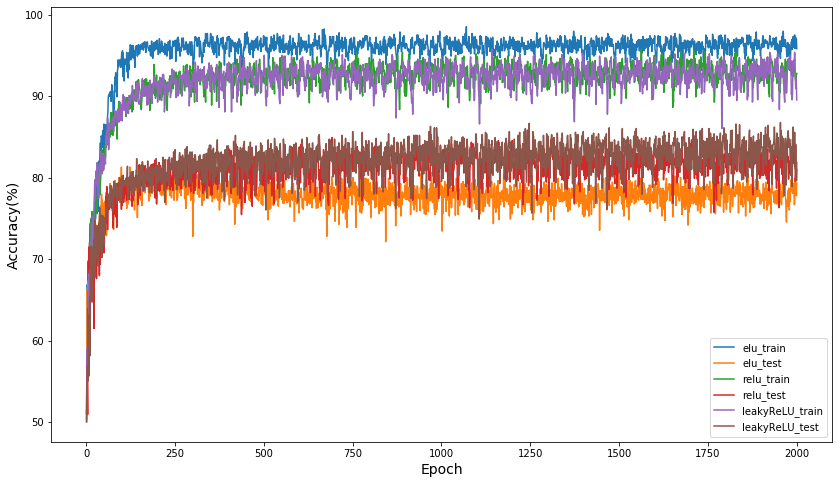

In [106]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 8))

# plt.title("Activation Function comparision(DeepConvNet)", fontsize=18)
plt.ylabel("Accuracy(%)", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
x = np.arange(1, len(train_acc)+1)
plt.plot(x, elu_train, label='elu_train')
plt.plot(x, elu_test, label="elu_test")
x_relu = np.arange(1, len(relu_train)+1)
plt.plot(x_relu, relu_train, label="relu_train")
plt.plot(x_relu, relu_test, label="relu_test")
plt.plot(x, leakyrelu_train, label="leakyReLU_train")
plt.plot(x, leakyrelu_test, label="leakyReLU_test")
# plt.plot(x, train_acc, label="train_acc")
# plt.plot(x, test_acc, label="test_acc")
plt.legend()
plt.show()

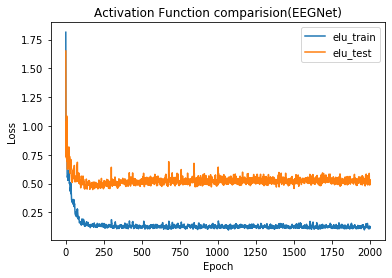

In [102]:
plt.figure()

# plt.title("Activation Function comparision(EEGNet)")
plt.ylabel("Loss")
plt.xlabel("Epoch")
x = np.arange(1, len(train_loss)+1)
plt.plot(x, train_loss, label="train")
plt.plot(x, test_loss, label="test")
plt.legend()
plt.show()

In [103]:
print(max(relu_test))

85.0


In [104]:
# model_load = EEGNet().to(device)
# model_load.load_state_dict(torch.load(".\EEGNet_weight.pt"))
model_load = torch.load('DeepConvNet_model.pt', map_location=device)
model_load.eval()

test_loss, correct = 0, 0
pred = model_load(x_test)
test_loss += loss_fn(pred, y_test).item()
correct += (pred.argmax(1) == y_test).type(torch.float).sum().item()

correct /= len(x_test)

print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
print(model_load)
summary(model_load, (1, 2, 750))

Test Error: 
 Accuracy: 80.4%, Avg loss: 0.520288 

DeepConvNet(
  (conv1): Conv2d(1, 25, kernel_size=(1, 5), stride=(1, 1))
  (conv2): Conv2d(25, 25, kernel_size=(2, 1), stride=(1, 1))
  (batchnorm1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(25, 50, kernel_size=(1, 5), stride=(1, 1))
  (batchnorm2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv4): Conv2d(50, 100, kernel_size=(1, 5), stride=(1, 1))
  (batchnorm3): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dro